In [4]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import hvplot.pandas
import esri2gpd
import carto2gpd
import seaborn as sns

np.random.seed(42)

In [5]:
pd.options.display.max_columns = 999

In [6]:
plt.rcParams['figure.figsize'] = (10,6)

## Lecture 12B: Predictive Modeling Part 2
Nov 29, 2021


## Housekeeping

- HW #7 (required) posted last week, due in one week on Monday 12/06
    - Includes final project proposal
    - Predictive modeling of housing prices in Philadelphia
- Final project due on December 20

## Picking up where we left off

We'll start with an exercise to add additional distance-based features to our housing price model...

## Spatial amenity/disamenity features

**The strategy**

- Get the data for a certain type of amenity, e.g., restaurants, bars, or disamenity, e.g., crimes
    - Data sources: 311 requests, crime incidents, Open Street Map
- Use scikit learn's nearest neighbor algorithm to calculate the distance from each sale to its nearest neighbor in the amenity/disamenity datasets

## Examples of new possible features...

Distance from each sale to:

- **Graffiti 311 Calls (last lecture)**
- **Subway Stops (last lecture)**
- Universities
- Parks
- City Hall
- New Construction Permits
- Aggravated Assaults
- Abandoned Vehicle 311 Calls

In [7]:
# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Model selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Pipelines
from sklearn.pipeline import make_pipeline

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder

# Neighbors
from sklearn.neighbors import NearestNeighbors

Load and clean the data:

In [8]:
# the CARTO API url
carto_url = "https://phl.carto.com/api/v2/sql"

# The table name
table_name = "opa_properties_public"

# Only pull 2019 sales for single family residential properties
where = "sale_date >= '2019-01-01' AND sale_date < '2020-01-01'" 
where = where + " AND category_code_description = 'Single Family'"

# Run the query
salesRaw = carto2gpd.get(carto_url, table_name, where=where)

# Optional: put it a reproducible order for test/training splits later
salesRaw = salesRaw.sort_values("parcel_number")

# The feature columns we want to use
cols = [
    "sale_price",
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
    "exterior_condition",
    "zip_code",
    "geometry"
]

# Trim to these columns and remove NaNs
sales = salesRaw[cols].dropna()

# Trim zip code to only the first five digits
sales['zip_code'] = sales['zip_code'].astype(str).str.slice(0, 5)

# Trim very low and very high sales
valid = (sales['sale_price'] > 3000) & (sales['sale_price'] < 1e6)
sales = sales.loc[valid]

In [9]:
len(sales)

18748

Add new distance-based features:

In [10]:
def get_xy_from_geometry(df):
    """
    Return a numpy array with two columns, where the 
    first holds the `x` geometry coordinate and the second 
    column holds the `y` geometry coordinate
    
    Note: this works with both Point() and Polygon() objects.
    """
    # NEW: use the centroid.x and centroid.y to support Polygon() and Point() geometries 
    x = df.geometry.centroid.x
    y = df.geometry.centroid.y
    
    return np.column_stack((x, y)) # stack as columns

In [11]:
# Convert to meters and EPSG=3857
sales_3857 = sales.to_crs(epsg=3857)

# Extract x/y for sales
salesXY = get_xy_from_geometry(sales_3857)

### Example #1: 311 Graffiti Calls

Source: https://www.opendataphilly.org/dataset/311-service-and-information-requests

Download the data:

In [12]:
# Select only those for grafitti and in 2019
where = "requested_datetime >= '01-01-2019' and requested_datetime < '01-01-2020'"
where = where + " AND service_name = 'Graffiti Removal'"

# Pull the subset we want
graffiti = carto2gpd.get(carto_url, "public_cases_fc", where=where)

# Remove rows with missing geometries
graffiti = graffiti.loc[graffiti.geometry.notnull()]

Get the x/y coordinates for the grafitti calls:

In [13]:
# Convert to meters in EPSG=3857
graffiti_3857 = graffiti.to_crs(epsg=3857)

# Extract x/y for grafitti calls
graffitiXY = get_xy_from_geometry(graffiti_3857)

Run the neighbors algorithm to calculate the new feature:

In [14]:
# STEP 1: Initialize the algorithm
nbrs = NearestNeighbors(n_neighbors=5)

# STEP 2: Fit the algorithm on the "neighbors" dataset
nbrs.fit(graffitiXY)

# STEP 3: Get distances for sale to neighbors
grafDists, grafIndices = nbrs.kneighbors(salesXY) 

# STEP 4: Get average distance to neighbors
avgGrafDist = grafDists.mean(axis=1)

# Set zero distances to be small, but nonzero
# IMPORTANT: THIS WILL AVOID INF DISTANCES WHEN DOING THE LOG
avgGrafDist[avgGrafDist==0] = 1e-5

# STEP 5: Add the new feature
sales['logDistGraffiti'] = np.log10(avgGrafDist)

### Example #2: Subway stops

Use the `osmnx` package to get subway stops in Philly — we can use the `ox.geometries_from_polygon()` function.

- To select subway stations, we can use `station=subway`: see the [OSM Wikipedia](https://wiki.openstreetmap.org/wiki/Tag:station%3Dsubway)
- See [Lecture 9A](https://musa-550-fall-2020.github.io/slides/lecture-9A.html) for a reminder on osmnx!

In [15]:
import osmnx as ox

Get the geometry polygon for the Philadelphia city limits:

In [16]:
# Download the Philadelphia city limits
url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/arcgis/rest/services/City_Limits/FeatureServer/0"
city_limits = esri2gpd.get(url).to_crs(epsg=3857)

# Get the geometry from the city limits
city_limits_outline = city_limits.to_crs(epsg=4326).squeeze().geometry

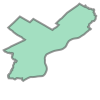

In [17]:
city_limits_outline

Use osmnx to query OpenStreetMap to get all subway stations within the city limits:

In [18]:
# Get the subway stops within the city limits
subway = ox.geometries_from_polygon(city_limits_outline, tags={"station": "subway"})

# Convert to 3857 (meters)
subway = subway.to_crs(epsg=3857)

Get the distance to the nearest subway station ($k=1$):

In [19]:
# STEP 1: x/y coordinates of subway stops (in EPGS=3857)
subwayXY = get_xy_from_geometry(subway.to_crs(epsg=3857))

# STEP 2: Initialize the algorithm
nbrs = NearestNeighbors(n_neighbors=1)

# STEP 3: Fit the algorithm on the "neighbors" dataset
nbrs.fit(subwayXY)

# STEP 4: Get distances for sale to neighbors
subwayDists, subwayIndices = nbrs.kneighbors(salesXY)

# STEP 5: add back to the original dataset
sales["logDistSubway"] = np.log10(subwayDists.mean(axis=1))

In [20]:
sales.head()

sale_price  total_livable_area  total_area  garage_spaces  fireplaces  \
8966     340000.0              1266.0     1622.70            1.0         0.0   
12568    397500.0              1436.0      739.68            0.0         0.0   
7866     285000.0               868.0      546.00            0.0         0.0   
15208    277500.0               890.0      683.70            0.0         0.0   
9447     453610.0              1320.0      896.00            0.0         0.0   

       number_of_bathrooms  number_of_bedrooms  number_stories  \
8966                   2.0                 3.0             2.0   
12568                  1.0                 3.0             3.0   
7866                   1.0                 3.0             2.0   
15208                  1.0                 2.0             2.0   
9447                   2.0                 3.0             3.0   

      exterior_condition zip_code                    geometry  \
8966                   4    19147  POINT (-75.14854 39.93144)   
12568                  2    19147  POINT (-75.14927 39.93033)   
7866                   2    19147  POINT (-75.14876 39.93011)   
15208                  3    19147  POINT (-75.14852 39.92954)   
9447                   2    19147  POINT (-75.14871 39.92962)   

       logDistGraffiti  logDistSubway  
8966          2.080292       3.338733  
12568         2.232137       3.330483  
7866          2.202199       3.341756  
15208         2.092351       3.347019  
9447          2.076465       3.342907

## Now, let's run the model...

In [21]:
# Numerical columns
num_cols = [
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
    "logDistGraffiti", # NEW
    "logDistSubway" # NEW
]

# Categorical columns
cat_cols = ["exterior_condition", "zip_code"]

In [22]:
# Set up the column transformer with two transformers
transformer = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

In [23]:
# Initialize the pipeline
# NOTE: only use 20 estimators here so it will run in a reasonable time
pipe = make_pipeline(
    transformer, RandomForestRegressor(n_estimators=20, random_state=42)
)

In [24]:
# Split the data 70/30
train_set, test_set = train_test_split(sales, test_size=0.3, random_state=42)

# the target labels
y_train = np.log(train_set["sale_price"])
y_test = np.log(test_set["sale_price"])

In [25]:
# Fit the training set
# REMINDER: use the training dataframe objects here rather than numpy array
pipe.fit(train_set, y_train);

In [26]:
# What's the test score?
# REMINDER: use the test dataframe rather than numpy array
pipe.score(test_set, y_test)

0.6272324828736331

### Can we improve on this?

## Exercise from last lecture: How about other spatial features?

- I've listed out several other types of potential sources of new distance-based features from OpenDataPhilly
- Choose a few and add new features
- Re-fit the model and evalute the performance on the test set and feature importances

### Example 1: Universities

New feature: Distance to the *nearest* university/college

- Source: [OpenDataPhilly](https://www.opendataphilly.org/dataset/philadelphia-universities-and-colleges)
- GeoService URL: https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/Universities_Colleges/FeatureServer/0


In [27]:
# Get the data
url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/Universities_Colleges/FeatureServer/0"
univs = esri2gpd.get(url)

# Get the X/Y
univXY = get_xy_from_geometry(univs.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=1)
nbrs.fit(univXY)
univDists, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales['logDistUniv'] = np.log10(univDists.mean(axis=1))

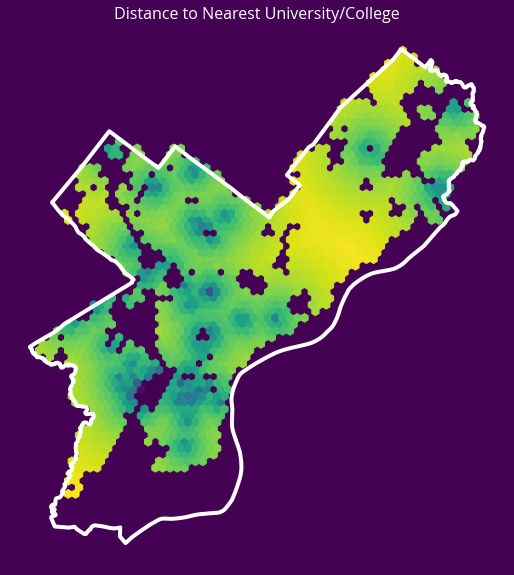

In [28]:
fig, ax = plt.subplots(figsize=(10,10), facecolor=plt.get_cmap('viridis')(0))

x = salesXY[:,0]
y = salesXY[:,1]
ax.hexbin(x, y, C=np.log10(univDists.mean(axis=1)), gridsize=60)

# Plot the city limits
city_limits.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title("Distance to Nearest University/College", fontsize=16, color='white');

### Example 2: Parks

New feature: Distance to the *nearest* park centroid

* Source: [OpenDataPhilly](https://www.opendataphilly.org/dataset/ppr-properties)
* GeoService URL: https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/PPR_Properties/FeatureServer/0

**Notes** 
- The park geometries are *polygons*, so you'll need to get the `x` and `y` coordinates of the park *centroids* and calculate the distance to these centroids. 
- You can use the `geometry.centroid.x` and `geometry.centroid.y` values to access these coordinates.

In [29]:
# Get the data
url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/PPR_Properties/FeatureServer/0"
parks = esri2gpd.get(url)

# Get the X/Y
parksXY = get_xy_from_geometry(parks.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=1)
nbrs.fit(parksXY)
parksDists, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales["logDistParks"] = np.log10(parksDists.mean(axis=1))

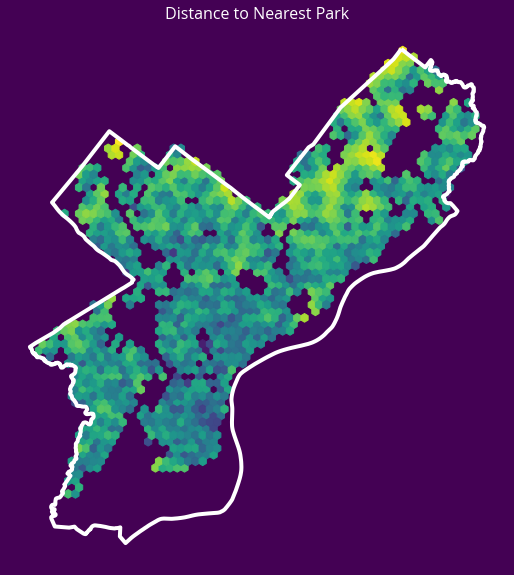

In [30]:
fig, ax = plt.subplots(figsize=(10, 10), facecolor=plt.get_cmap("viridis")(0))

x = salesXY[:, 0]
y = salesXY[:, 1]
ax.hexbin(x, y, C=np.log10(parksDists.mean(axis=1)), gridsize=60)

# Plot the city limits
city_limits.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title("Distance to Nearest Park", fontsize=16, color="white");

### Example 3: City Hall

New feature: Distance to City Hall.

* Source: [OpenDataPhilly](https://www.opendataphilly.org/dataset/city-landmarks)
* GeoService URL: https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/CITY_LANDMARKS/FeatureServer/0

**Notes**

- To identify City Hall, you'll need to pull data where "NAME='City Hall'" and "FEAT_TYPE='Municipal Building'"
- As with the parks, the geometry will be a *polygon*, so you should calculate the distance to the *centroid* of the City Hall polygon

In [31]:
# Get the data
url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/CITY_LANDMARKS/FeatureServer/0"
cityHall = esri2gpd.get(
    url, where="NAME = 'City Hall' AND FEAT_TYPE = 'Municipal Building'"
)

# Get the X/Y
cityHallXY = get_xy_from_geometry(cityHall.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=1)
nbrs.fit(cityHallXY)
cityHallDist, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales["logDistCityHall"] = np.log10(cityHallDist.mean(axis=1))

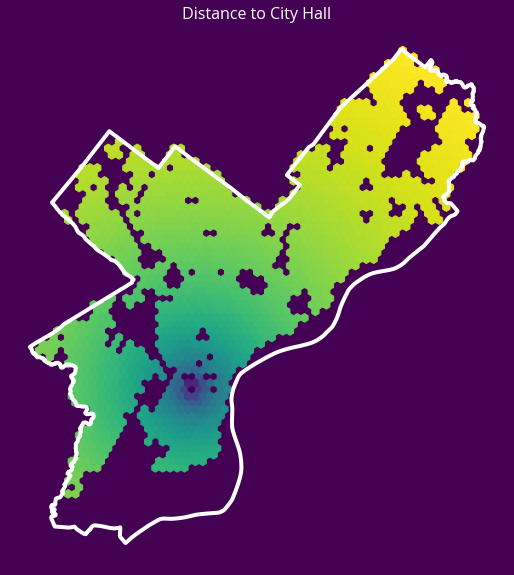

In [32]:
fig, ax = plt.subplots(figsize=(10, 10), facecolor=plt.get_cmap("viridis")(0))

x = salesXY[:, 0]
y = salesXY[:, 1]
ax.hexbin(x, y, C=np.log10(cityHallDist.mean(axis=1)), gridsize=60)

# Plot the city limits
city_limits.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title("Distance to City Hall", fontsize=16, color="white");

### Example 4: New Construction Permits

New feature: Distance to the 5 nearest new construction permits from 2019

* Source: [OpenDataPhilly](https://www.opendataphilly.org/dataset/licenses-and-inspections-building-permits)
* CARTO table name: "permits"

**Notes**

* You can pull new construction permits only by selecting where `permitdescription` equals 'NEW CONSTRUCTION PERMIT'
* You can select permits from only 2019 using the `permitissuedate` column

In [33]:
# Table name
table_name = "permits"

# Where clause
where = "permitissuedate >= '2019-01-01' AND permitissuedate < '2020-01-01'"
where = where + " AND permitdescription='NEW CONSTRUCTION PERMIT'"

# Query
permits = carto2gpd.get(carto_url, table_name, where=where)

# Remove missing
permits = permits.loc[permits.geometry.notnull()]

# Get the X/Y
permitsXY = get_xy_from_geometry(permits.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=5)
nbrs.fit(permitsXY)
permitsDist, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales["logDistPermits"] = np.log10(permitsDist.mean(axis=1))

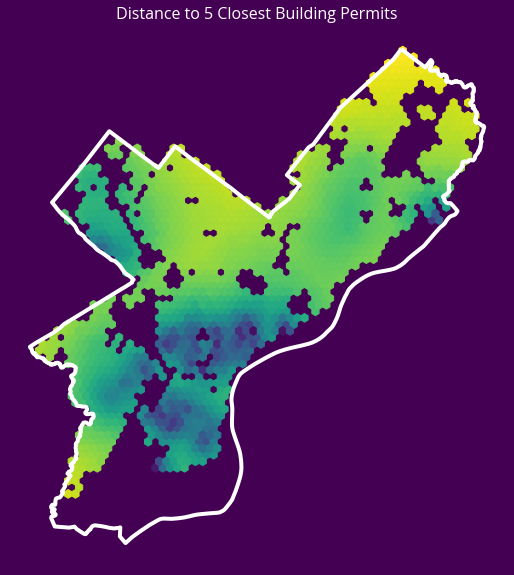

In [34]:
fig, ax = plt.subplots(figsize=(10, 10), facecolor=plt.get_cmap("viridis")(0))

x = salesXY[:, 0]
y = salesXY[:, 1]
ax.hexbin(x, y, C=np.log10(permitsDist.mean(axis=1)), gridsize=60)

# Plot the city limits
city_limits.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title("Distance to 5 Closest Building Permits", fontsize=16, color="white");

### Example 5: Aggravated Assaults

New feature: Distance to the 5 nearest aggravated assaults in 2019

* Source: [OpenDataPhilly](https://www.opendataphilly.org/dataset/crime-incidents)
* CARTO table name: "incidents_part1_part2"

**Notes**

* You can pull aggravated assaults only by selecting where `Text_General_Code` equals 'Aggravated Assault No Firearm' or 'Aggravated Assault Firearm'
* You can select crimes from only 2019 using the `dispatch_date` column

In [35]:
# Table name
table_name = "incidents_part1_part2"

# Where selection
where = "dispatch_date >= '2019-01-01' AND dispatch_date < '2020-01-01'"
where = where + " AND Text_General_Code IN ('Aggravated Assault No Firearm', 'Aggravated Assault Firearm')"

# Query
assaults = carto2gpd.get(carto_url, table_name, where=where)

# Remove missing 
assaults = assaults.loc[assaults.geometry.notnull()]
    
# Get the X/Y
assaultsXY = get_xy_from_geometry(assaults.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=5)
nbrs.fit(assaultsXY)
assaultDists, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales['logDistAssaults'] = np.log10(assaultDists.mean(axis=1))

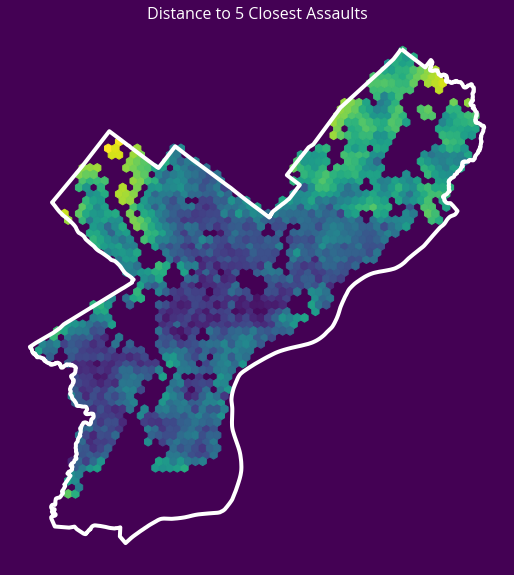

In [36]:
fig, ax = plt.subplots(figsize=(10, 10), facecolor=plt.get_cmap("viridis")(0))

x = salesXY[:, 0]
y = salesXY[:, 1]
ax.hexbin(x, y, C=np.log10(assaultDists.mean(axis=1)), gridsize=60)

# Plot the city limits
city_limits.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title("Distance to 5 Closest Assaults", fontsize=16, color="white");

### Example 6: Abandonded Vehicle 311 Calls

New feature: Distance to the 5 nearest abandoned vehicle 311 calls in 2019

* Source: [OpenDataPhilly](https://www.opendataphilly.org/dataset/311-service-and-information-requests)
* CARTO table name: "public_cases_fc"

**Notes**

* You can pull abandonded vehicle calls only by selecting where `service_name` equals 'Abandoned Vehicle'
* You can select crimes from only 2019 using the `requested_datetime` column

In [37]:
# Table name
table_name = "public_cases_fc"

# Where selection
where = "requested_datetime >= '2019-01-01' AND requested_datetime < '2020-01-01'"
where = where + " AND service_name = 'Abandoned Vehicle'"

# Query
cars = carto2gpd.get(carto_url, table_name, where=where)

# Remove missing
cars = cars.loc[cars.geometry.notnull()]

# Get the X/Y
carsXY = get_xy_from_geometry(cars.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=5)
nbrs.fit(carsXY)
carDists, _ = nbrs.kneighbors(salesXY)

# Handle any sales that have 0 distances
carDists[carDists == 0] = 1e-5  # a small, arbitrary value

# Add the new feature
sales["logDistCars"] = np.log10(carDists.mean(axis=1))

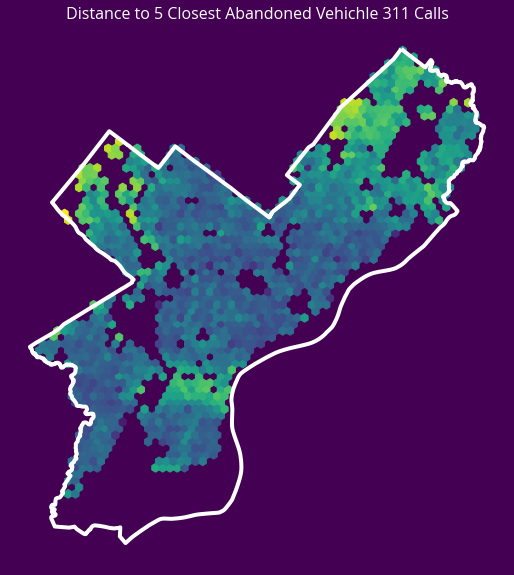

In [38]:
fig, ax = plt.subplots(figsize=(10, 10), facecolor=plt.get_cmap("viridis")(0))

x = salesXY[:, 0]
y = salesXY[:, 1]
ax.hexbin(x, y, C=np.log10(carDists.mean(axis=1)), gridsize=60)

# Plot the city limits
city_limits.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title(
    "Distance to 5 Closest Abandoned Vehichle 311 Calls", fontsize=16, color="white"
);

## Fit the updated model

In [39]:
# Numerical columns
num_cols = [
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
    "logDistGraffiti", # NEW
    "logDistSubway", # NEW
    "logDistUniv", # NEW
    "logDistParks", # NEW
    "logDistCityHall", # NEW 
    "logDistPermits", # NEW
    "logDistAssaults", # NEW
    "logDistCars" # NEW
]

# Categorical columns
cat_cols = ["exterior_condition", "zip_code"]

In [40]:
# Set up the column transformer with two transformers
transformer = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

In [41]:
# Two steps in pipeline: preprocessor and then regressor
pipe = make_pipeline(
    transformer, RandomForestRegressor(n_estimators=20, random_state=42)
)

In [42]:
# Split the data 70/30
train_set, test_set = train_test_split(sales, test_size=0.3, random_state=42)

# the target labels
y_train = np.log(train_set["sale_price"])
y_test = np.log(test_set["sale_price"])

In [43]:
# Fit the training set
pipe.fit(train_set, y_train);

In [44]:
# What's the test score?
pipe.score(test_set, y_test)

0.669637996745974

### More improvement!

### Feature importances:

In [45]:
# The one-hot step
ohe = transformer.named_transformers_["cat"]

# One column for each category type!
ohe_cols = ohe.get_feature_names()

# Full list of columns is numerical + one-hot
features = num_cols + list(ohe_cols)

# The regressor
regressor = pipe["randomforestregressor"]

# Create the dataframe with importances
importance = pd.DataFrame(
    {"Feature": features, "Importance": regressor.feature_importances_}
)

# Sort importance in descending order and get the top
importance = importance.sort_values("Importance", ascending=False).iloc[:30]

# Plot
importance.hvplot.barh(
    x="Feature", y="Importance", flip_yaxis=True, height=500
)

:Bars   [Feature]   (Importance)

## Part 2: Predicting bikeshare demand in Philadelphia

**The technical problem**: predict bikeshare trip counts for the Indego bikeshare in Philadelphia



## The policy question: how to best expand a bikeshare program?

- Bikeshares typically require substantial capital when first launching, about \\$4,000 to \\$5,000 per bike
- Once launched, revenue from riders typically covers about 80 percent of operating costs
- Ridership peaks in busy downtown hubs, but how to best expand outwards, often to low-density and low-income communities?
- Important cost/benefit questions of how/where to expand to maximize ridership and access and minimize the need for outside subsidies

For more info, see [this blog post](https://www.pewtrusts.org/en/research-and-analysis/blogs/stateline/2016/03/24/despite-popularity-bike-share-programs-often-need-subsidies) from Pew

## Using predictive modeling as a policy tool

- Construct a predictive model for trip counts by stations in a bikeshare
- Use this model to estimate and map out the ridership for potential stations in new areas
- Use the cost per ride to estimate the additional revenue added
- Compare this additional revenue to the cost of adding new stations

## What are the key assumptions here?

**Most important:** adding new stations in new areas will not affect the demand for existing stations.

This allows the results from the predictive model for demand, built on existing stations, to translate to new stations. 

The key assumption is that the bikeshare is not yet at full capacity, and riders in new areas will not decrease the demand in other areas.

## Is this a good assumption?

- Given that the bikeshare is looking to expand, it's a safe bet that they believe the program is not yet at full capacity
- This is verifiable with existing data — examine trip counts in neighboring stations when a new station opens up. 

**Typically, this is a pretty safe assumption.** But I encourage you to use historical data to verify it!

## Getting trip data for the Indego bike share

- Available by quarter from: https://www.rideindego.com/about/data/
- I've pulled historic trip data from 2018 and 2019 and combined into a single CSV file (available in the data folder)

The data page also includes the live status of all of the stations in the system.

API endpoint: http://www.rideindego.com/stations/json

**Two important columns:**

- `totalDocks`: the total number of docks at each station
- `kioskId`: the unique identifier for each station

In [46]:
import requests

In [47]:
# API endpoint
API_endpoint = "http://www.rideindego.com/stations/json/"

# Get the JSON
stations_geojson = requests.get(API_endpoint).json()

# Convert to a GeoDataFrame
stations = gpd.GeoDataFrame.from_features(stations_geojson, crs="EPSG:4326")

In [48]:
stations.head()

geometry    id                               name  \
0  POINT (-75.16374 39.95378)  3004  Municipal Services Building Plaza   
1  POINT (-75.14403 39.94733)  3005                  Welcome Park, NPS   
2  POINT (-75.20311 39.95220)  3006                      40th & Spruce   
3  POINT (-75.15993 39.94517)  3007             11th & Pine, Kahn Park   
4  POINT (-75.15114 39.97944)  3008          Temple University Station   

             coordinates  totalDocks  docksAvailable  bikesAvailable  \
0  [-75.16374, 39.95378]          30              16              11   
1  [-75.14403, 39.94733]          13               9               3   
2   [-75.20311, 39.9522]          17              15               2   
3  [-75.15993, 39.94517]          20              17               2   
4  [-75.15114, 39.97944]          19              17               2   

   classicBikesAvailable  smartBikesAvailable  electricBikesAvailable  \
0                      7                    0                       4   
1                      2                    0                       1   
2                      1                    0                       1   
3                      2                    0                       0   
4                      2                    0                       0   

   rewardBikesAvailable  rewardDocksAvailable  kioskStatus kioskPublicStatus  \
0                    12                    16  FullService            Active   
1                     3                     9  FullService            Active   
2                     2                    15  FullService            Active   
3                     3                    17  FullService            Active   
4                     2                    17  FullService            Active   

  kioskConnectionStatus  kioskType               addressStreet   addressCity  \
0                Active          1  1401 John F. Kennedy Blvd.  Philadelphia   
1                Active          1              191 S. 2nd St.  Philadelphia   
2                Active          1             246 S. 40th St.  Philadelphia   
3                Active          1             328 S. 11th St.  Philadelphia   
4                Active          1           1076 Berks Street  Philadelphia   

  addressState addressZipCode  \
0           PA          19102   
1           PA          19106   
2           PA          19104   
3           PA          19107   
4           PA          19122   

                                               bikes closeTime eventEnd  \
0  [{'dockNumber': 3, 'isElectric': False, 'isAva...      None     None   
1  [{'dockNumber': 9, 'isElectric': False, 'isAva...      None     None   
2  [{'dockNumber': 1, 'isElectric': True, 'isAvai...      None     None   
3  [{'dockNumber': 2, 'isElectric': False, 'isAva...      None     None   
4  [{'dockNumber': 4, 'isElectric': False, 'isAva...      None     None   

  eventStart  isEventBased  isVirtual  kioskId notes openTime publicText  \
0       None         False      False     3004  None     None              
1       None         False      False     3005  None     None              
2       None         False      False     3006  None     None              
3       None         False      False     3007  None     None              
4       None         False      False     3008  None     None              

  timeZone  trikesAvailable  latitude  longitude  
0     None                0  39.95378  -75.16374  
1     None                0  39.94733  -75.14403  
2     None                0  39.95220  -75.20311  
3     None                0  39.94517  -75.15993  
4     None                0  39.97944  -75.15114

### Let's plot the stations, colored by the number of docks

In [49]:
import contextily as ctx

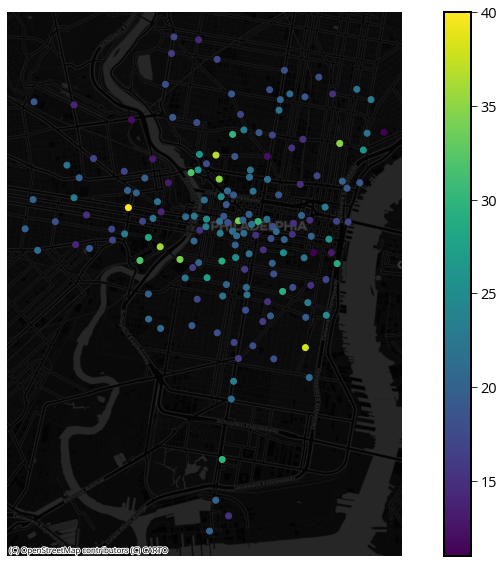

In [50]:
fig, ax = plt.subplots(figsize=(15, 10))

# stations
stations_3857 = stations.to_crs(epsg=3857)
stations_3857.plot(ax=ax, column='totalDocks', legend=True)

# plot the basemap underneath
ctx.add_basemap(ax=ax, crs=stations_3857.crs, source=ctx.providers.CartoDB.DarkMatter)

ax.set_axis_off()

### Load all trips from 2018 and 2019

In [51]:
all_trips = pd.read_csv("./data/indego-trips-2018-2019.csv.tar.gz")

/Users/nhand/opt/miniconda3/envs/musa-550-fall-2021/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (10,14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [52]:
all_trips.head()

trip_id  duration           start_time             end_time  \
0  223869188        18  2018-01-01 00:24:00  2018-01-01 00:42:00   
1  223905597       572  2018-01-01 00:38:00  2018-01-01 10:10:00   
2  223872811        22  2018-01-01 00:48:00  2018-01-01 01:10:00   
3  223872810        21  2018-01-01 01:03:00  2018-01-01 01:24:00   
4  223872809         4  2018-01-01 01:05:00  2018-01-01 01:09:00   

   start_station  start_lat  start_lon  end_station    end_lat    end_lon  \
0           3124  39.952950 -75.139793         3073  39.961430 -75.152420   
1           3023  39.950481 -75.172859         3066  39.945610 -75.173477   
2           3026  39.941380 -75.145638         3023  39.950481 -75.172859   
3           3045  39.947922 -75.162369         3037  39.954239 -75.161377   
4           3115  39.972630 -75.167572         3058  39.967159 -75.170013   

  bike_id  plan_duration trip_route_category passholder_type bike_type  
0    3708           30.0             One Way        Indego30       NaN  
1    3288          365.0             One Way       Indego365       NaN  
2   11735           30.0             One Way        Indego30       NaN  
3    5202           30.0             One Way        Indego30       NaN  
4    5142           30.0             One Way        Indego30       NaN

### Dependent variable: total trips by starting station

In [53]:
start_trips = (
    all_trips.groupby("start_station").size().reset_index(name="total_start_trips")
)

In [54]:
start_trips.head()

start_station  total_start_trips
0           3000                469
1           3004              13712
2           3005               8253
3           3006               8843
4           3007              20323

In [55]:
# Now merge in the geometry for each station
bike_data = (
    stations[["geometry", "kioskId"]]
    .merge(start_trips, left_on="kioskId", right_on="start_station")
    .to_crs(epsg=3857)
)

Let's plot it...

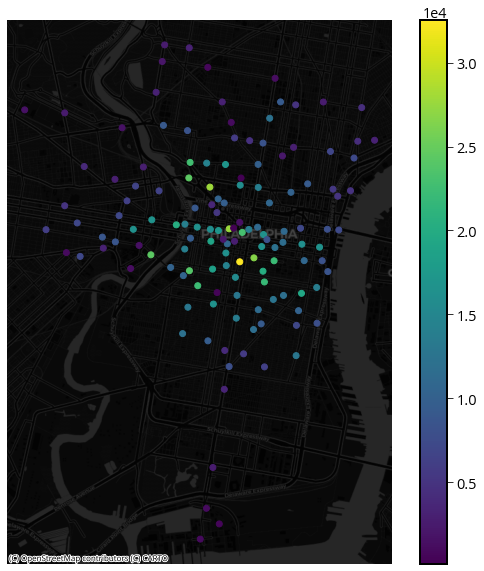

In [56]:
fig, ax = plt.subplots(figsize=(10,10))

# stations
bike_data.plot(ax=ax, column='total_start_trips', legend=True)

# plot the basemap underneath
ctx.add_basemap(ax=ax, crs=bike_data.crs, source=ctx.providers.CartoDB.DarkMatter)

ax.set_axis_off()

Trips are clearly concentrated in Center City...

## What features to use?

There are lots of possible options. Generally speaking, the possible features fall into a few different categories:

- **Internal**
    - e.g., the number of docks per station
- **Demographic (Census)**    
    - e.g., population, income, percent commuting by car, percent with bachelor's degree or higher, etc
- **Amenities/Disamenities**
    - e.g., distance to nearest crimes, restaurants, parks, within Center City, etc
- **Transportation network**
    - e.g., distance to nearest bus stop, interesection nodes, nearest subway stop
- **Neighboring stations**
    - e.g., average trips of nearest stations, distance to nearest stations
    
**Let's add a few from each category...**

## 1. Internal characteristics

Let's use the number of docks per stations:

In [57]:
bike_data = bike_data.merge(stations[["kioskId", "totalDocks"]], on="kioskId")
bike_data.head()

geometry  kioskId  start_station  \
0  POINT (-8367189.263 4859227.987)     3004           3004   
1  POINT (-8364995.156 4858291.368)     3005           3005   
2  POINT (-8371571.911 4858998.543)     3006           3006   
3  POINT (-8366765.136 4857977.729)     3007           3007   
4  POINT (-8365786.637 4862955.006)     3008           3008   

   total_start_trips  totalDocks  
0              13712          30  
1               8253          13  
2               8843          17  
3              20323          20  
4               4887          19

## 2. Census demographic data

We'll try out percent commuting by car first.

In [58]:
import cenpy

/Users/nhand/opt/miniconda3/envs/musa-550-fall-2021/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


In [59]:
acs = cenpy.remote.APIConnection("ACSDT5Y2019")

In [60]:
acs.varslike("B08134").sort_index().iloc[:15]

label  \
B08134_001E                                   Estimate!!Total:   
B08134_002E             Estimate!!Total:!!Less than 10 minutes   
B08134_003E                 Estimate!!Total:!!10 to 14 minutes   
B08134_004E                 Estimate!!Total:!!15 to 19 minutes   
B08134_005E                 Estimate!!Total:!!20 to 24 minutes   
B08134_006E                 Estimate!!Total:!!25 to 29 minutes   
B08134_007E                 Estimate!!Total:!!30 to 34 minutes   
B08134_008E                 Estimate!!Total:!!35 to 44 minutes   
B08134_009E                 Estimate!!Total:!!45 to 59 minutes   
B08134_010E               Estimate!!Total:!!60 or more minutes   
B08134_011E              Estimate!!Total:!!Car, truck, or van:   
B08134_012E  Estimate!!Total:!!Car, truck, or van:!!Less th...   
B08134_013E  Estimate!!Total:!!Car, truck, or van:!!10 to 1...   
B08134_014E  Estimate!!Total:!!Car, truck, or van:!!15 to 1...   
B08134_015E  Estimate!!Total:!!Car, truck, or van:!!20 to 2...   

                                                       concept predicateType  \
B08134_001E  MEANS OF TRANSPORTATION TO WORK BY TRAVEL TIME...           int   
B08134_002E  MEANS OF TRANSPORTATION TO WORK BY TRAVEL TIME...           int   
B08134_003E  MEANS OF TRANSPORTATION TO WORK BY TRAVEL TIME...           int   
B08134_004E  MEANS OF TRANSPORTATION TO WORK BY TRAVEL TIME...           int   
B08134_005E  MEANS OF TRANSPORTATION TO WORK BY TRAVEL TIME...           int   
B08134_006E  MEANS OF TRANSPORTATION TO WORK BY TRAVEL TIME...           int   
B08134_007E  MEANS OF TRANSPORTATION TO WORK BY TRAVEL TIME...           int   
B08134_008E  MEANS OF TRANSPORTATION TO WORK BY TRAVEL TIME...           int   
B08134_009E  MEANS OF TRANSPORTATION TO WORK BY TRAVEL TIME...           int   
B08134_010E  MEANS OF TRANSPORTATION TO WORK BY TRAVEL TIME...           int   
B08134_011E  MEANS OF TRANSPORTATION TO WORK BY TRAVEL TIME...           int   
B08134_012E  MEANS OF TRANSPORTATION TO WORK BY TRAVEL TIME...           int   
B08134_013E  MEANS OF TRANSPORTATION TO WORK BY TRAVEL TIME...           int   
B08134_014E  MEANS OF TRANSPORTATION TO WORK BY TRAVEL TIME...           int   
B08134_015E  MEANS OF TRANSPORTATION TO WORK BY TRAVEL TIME...           int   

              group limit predicateOnly hasGeoCollectionSupport  \
B08134_001E  B08134     0           NaN                     NaN   
B08134_002E  B08134     0           NaN                     NaN   
B08134_003E  B08134     0           NaN                     NaN   
B08134_004E  B08134     0           NaN                     NaN   
B08134_005E  B08134     0           NaN                     NaN   
B08134_006E  B08134     0           NaN                     NaN   
B08134_007E  B08134     0           NaN                     NaN   
B08134_008E  B08134     0           NaN                     NaN   
B08134_009E  B08134     0           NaN                     NaN   
B08134_010E  B08134     0           NaN                     NaN   
B08134_011E  B08134     0           NaN                     NaN   
B08134_012E  B08134     0           NaN                     NaN   
B08134_013E  B08134     0           NaN                     NaN   
B08134_014E  B08134     0           NaN                     NaN   
B08134_015E  B08134     0           NaN                     NaN   

                                        attributes required  
B08134_001E  B08134_001EA,B08134_001M,B08134_001MA      NaN  
B08134_002E  B08134_002EA,B08134_002M,B08134_002MA      NaN  
B08134_003E  B08134_003EA,B08134_003M,B08134_003MA      NaN  
B08134_004E  B08134_004EA,B08134_004M,B08134_004MA      NaN  
B08134_005E  B08134_005EA,B08134_005M,B08134_005MA      NaN  
B08134_006E  B08134_006EA,B08134_006M,B08134_006MA      NaN  
B08134_007E  B08134_007EA,B08134_007M,B08134_007MA      NaN  
B08134_008E  B08134_008EA,B08134_008M,B08134_008MA      NaN  
B08134_009E  B08134_009EA,B08134_009M,B08134_009MA      NaN  
B08134_010E  B08134_010EA,

In [61]:
# Means of Transportation to Work by Travel Time to Work
variables = ["NAME", "B08134_001E", "B08134_011E"]

# Pull data by census tract
census_data = acs.query(
    cols=variables,
    geo_unit="block group:*",
    geo_filter={"state": "42",
                "county": "101", 
                "tract": "*"},
)

# Convert to the data to floats
for col in variables[1:]:
    census_data[col] = census_data[col].astype(float)

# The percent commuting by car
census_data["percent_car"] = census_data["B08134_011E"] / census_data["B08134_001E"]

In [62]:
census_data.head()

NAME  B08134_001E  \
0  Block Group 1, Census Tract 9807, Philadelphia...          0.0   
1  Block Group 3, Census Tract 27.01, Philadelphi...        761.0   
2  Block Group 2, Census Tract 337.01, Philadelph...        445.0   
3  Block Group 3, Census Tract 337.01, Philadelph...       1205.0   
4  Block Group 2, Census Tract 205, Philadelphia ...        217.0   

   B08134_011E state county   tract block group  percent_car  
0          0.0    42    101  980700           1          NaN  
1        267.0    42    101  002701           3     0.350854  
2        400.0    42    101  033701           2     0.898876  
3        910.0    42    101  033701           3     0.755187  
4        132.0    42    101  020500           2     0.608295

Merge with block group geometries for Philadelphia:

In [63]:
acs.set_mapservice("tigerWMS_ACS2019")

Connection to American Community Survey: 5-Year Estimates: Detailed Tables 5-Year(ID: https://api.census.gov/data/id/ACSDT5Y2019)
With MapServer: Census ACS 2019 WMS

In [64]:
acs.mapservice.layers[10]

(ESRILayer) Census Block Groups

In [65]:
# Use SQL to return geometries only for Philadelphia County in PA
where_clause = "STATE = 42 AND COUNTY = 101"

# Query for tracts
block_groups = acs.mapservice.layers[10].query(where=where_clause)

/Users/nhand/opt/miniconda3/envs/musa-550-fall-2021/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1990: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  result[:] = values
/Users/nhand/opt/miniconda3/envs/musa-550-fall-2021/lib/python3.8/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [66]:
census_data = block_groups.merge(
    census_data,
    left_on=["STATE", "COUNTY", "TRACT", "BLKGRP"],
    right_on=["state", "county", "tract", "block group"],
)

Finally, let's merge the census data into our dataframe of features by spatially joining the stations and the block groups:

**Each station gets the census data associated with the block group the station is within.**

In [67]:
bike_data = gpd.sjoin(
    bike_data,
    census_data.to_crs(bike_data.crs)[["geometry", "percent_car"]],
    op="within",
).drop(labels=['index_right'], axis=1)

/Users/nhand/opt/miniconda3/envs/musa-550-fall-2021/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [68]:
bike_data.head()

geometry  kioskId  start_station  \
0    POINT (-8367189.263 4859227.987)     3004           3004   
17   POINT (-8367777.030 4859245.413)     3021           3021   
80   POINT (-8367386.298 4859137.951)     3108           3108   
130  POINT (-8367616.730 4858873.658)     3202           3202   
133  POINT (-8367644.560 4859267.196)     3205           3205   

     total_start_trips  totalDocks  percent_car  
0                13712          30     0.314632  
17               27615          34     0.314632  
80               22954          22     0.314632  
130               2683          21     0.314632  
133                128          20     0.314632

### "Impute" missing values with the median value

Note: scikit-learn contains preprocessing transformers to do more advanced imputation methods. [The documentation](https://scikit-learn.org/stable/modules/impute.html) contains a good description of the options. 

In particular, the `SimpleImputer` object (see the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)) can fill values based on the median, mean, most frequent value, or a constant value.

In [69]:
missing = bike_data['percent_car'].isnull()
bike_data.loc[missing, 'percent_car'] = bike_data['percent_car'].median()

## 3. Amenities/disamenities

Let's add two new features:

1. Distances to the nearest 10 restaurants from Open Street Map
1. Whether the station is located within Center City

### Restaurants

Search https://wiki.openstreetmap.org/wiki/Map_Features for OSM identifier of restaurants

In [70]:
restaurants = ox.geometries_from_polygon(
    city_limits_outline, tags={"amenity": "restaurant"}
).to_crs(epsg=3857)

restaurants.head()

amenity      created_by  \
element_type osmid                                   
node         333786044  restaurant  Potlatch 0.10f   
             566683522  restaurant             NaN   
             596230881  restaurant             NaN   
             596245658  restaurant             NaN   
             596245661  restaurant             NaN   

                                                    name     source  \
element_type osmid                                                    
node         333786044               Sam's Morning Glory  knowledge   
             566683522  Spring Garden Pizza & Restaurant        NaN   
             596230881                               NaN        NaN   
             596245658             Earth Bread & Brewery        NaN   
             596245661    Cresheim Valley Grain Exchange        NaN   

                       wheelchair                          geometry   cuisine  \
element_type osmid                                                              
node         333786044    limited  POINT (-8366653.605 4857351.702)       NaN   
             566683522        NaN  POINT (-8366499.795 4860429.601)     pizza   
             596230881        NaN  POINT (-8369759.051 4873925.895)       NaN   
             596245658        NaN  POINT (-8370151.987 4874548.737)       NaN   
             596245661        NaN  POINT (-8370191.995 4874609.053)  american   

                       addr:housenumber     addr:street    craft microbrewery  \
element_type osmid                                                              
node         333786044              NaN             NaN      NaN          NaN   
             566683522              NaN             NaN      NaN          NaN   
             596230881              NaN             NaN      NaN          NaN   
             596245658             7136  Germantown Ave  brewery          yes   
             596245661             7152  Germantown Ave      NaN          NaN   

                       outdoor_seating addr:city addr:postcode phone  \
element_type osmid                                                     
node         333786044             NaN       NaN           NaN   NaN   
             566683522             NaN       NaN           NaN   NaN   
             596230881             NaN       NaN           NaN   NaN   
             596245658             NaN       NaN           NaN   NaN   
             596245661             yes       NaN           NaN   NaN   

                       diet:vegetarian opening_hours website description  \
element_type osmid                                                         
node         333786044             NaN           NaN     NaN         NaN   
             566683522             NaN           NaN     NaN         NaN   
             596230881             NaN           NaN     NaN         NaN   
             596245658             NaN           NaN     NaN         NaN   
             596245661             NaN           NaN     NaN         NaN   

                       addr:state addr:housename designation diet:vegan email  \
element_type osmid                                                              
node         333786044        NaN            NaN         NaN        NaN   NaN   
             566683522        NaN            NaN         NaN        NaN   NaN   
             596230881        NaN            NaN         NaN        NaN   NaN   
             596245658        NaN            NaN         NaN        NaN   NaN   
             596245661        NaN            NaN         NaN        NaN   NaN   

                        fax  bar takeaway smoking alt_name short_name name:zh  \
element_type osmid                                                              
node         333786044  NaN  NaN      NaN     NaN      NaN        NaN     NaN   
             566683522  NaN  NaN      NaN     NaN      NaN        NaN     NaN   
             596230881  NaN  NaN      NaN     NaN      NaN        NaN     NaN   
   

Get x/y values for the stations:

In [71]:
stationsXY = get_xy_from_geometry(bike_data)

In [72]:
# STEP 1: x/y coordinates of restaurants (in EPGS=3857)
restsXY = get_xy_from_geometry(restaurants.to_crs(epsg=3857))

# STEP 2: Initialize the algorithm
nbrs = NearestNeighbors(n_neighbors=10)

# STEP 3: Fit the algorithm on the "neighbors" dataset
nbrs.fit(restsXY)

# STEP 4: Get distances for stations to neighbors
restsDists, restsIndices = nbrs.kneighbors(stationsXY)

# STEP 5: add back to the original dataset
bike_data['logDistRests'] = np.log10(restsDists.mean(axis=1))

In [73]:
bike_data.head()

geometry  kioskId  start_station  \
0    POINT (-8367189.263 4859227.987)     3004           3004   
17   POINT (-8367777.030 4859245.413)     3021           3021   
80   POINT (-8367386.298 4859137.951)     3108           3108   
130  POINT (-8367616.730 4858873.658)     3202           3202   
133  POINT (-8367644.560 4859267.196)     3205           3205   

     total_start_trips  totalDocks  percent_car  logDistRests  
0                13712          30     0.314632      2.593366  
17               27615          34     0.314632      2.528659  
80               22954          22     0.314632      2.598887  
130               2683          21     0.314632      2.220684  
133                128          20     0.314632      2.607155

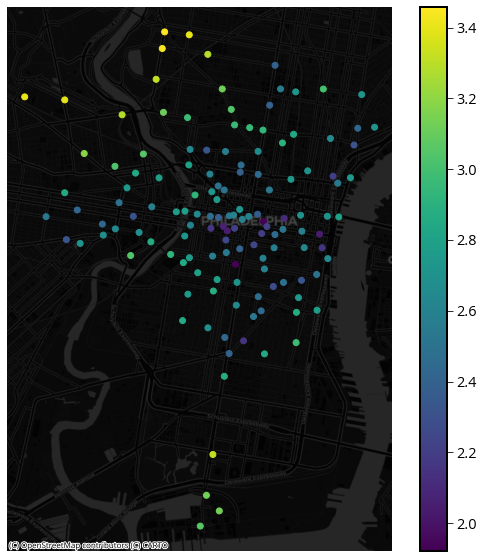

In [74]:
fig, ax = plt.subplots(figsize=(10,10))

# stations
bike_data.plot(ax=ax, column='logDistRests', legend=True)

# plot the basemap underneath
ctx.add_basemap(ax=ax, crs=bike_data.crs, source=ctx.providers.CartoDB.DarkMatter)

ax.set_axis_off()

### Within the Center City business district

Available from [OpenDataPhilly](https://www.opendataphilly.org/dataset/center-city-business-improvement-district)

In [75]:
url = "http://data.phl.opendata.arcgis.com/datasets/95366b115d93443eae4cc6f498cb3ca3_0.geojson"
ccbd = gpd.read_file(url).to_crs(epsg=3857)

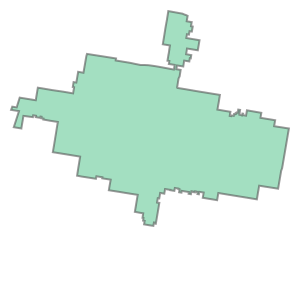

In [76]:
ccbd_geo = ccbd.squeeze().geometry

ccbd_geo

In [77]:
# Add the new feature: 1 if within CC and 0 otherwise
bike_data['within_centerCity'] = bike_data.geometry.within(ccbd_geo).astype(int)

## 4. Transportation Network

- Let's add a feature that calculates the distance to the nearest intersections
- We can use the osmnx package

In [78]:
xmin, ymin, xmax, ymax = bike_data.to_crs(epsg=4326).total_bounds

In [79]:
ox.graph_from_bbox?

Create the graph object from the bounding box:

In [80]:
G = ox.graph_from_bbox(ymax, ymin, xmax, xmin, network_type='bike')

G

Let's plot the graph using the built-in plotting from osmnx:

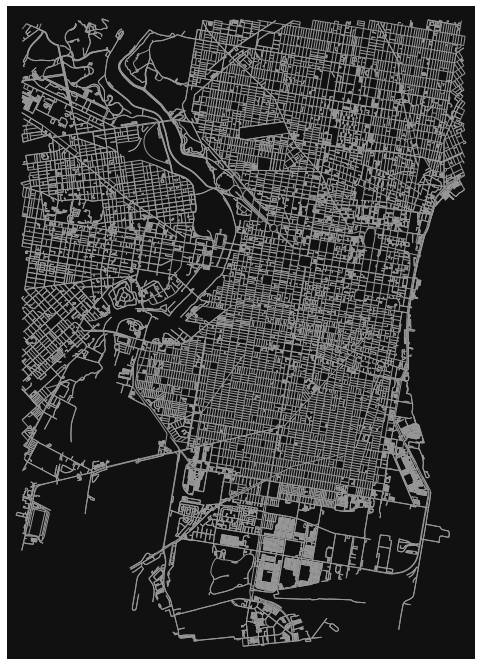

In [81]:
ox.plot_graph(G, figsize=(12, 12), node_size=0);

Now extract the nodes (intersections) from the graph into a GeoDataFrame:

In [84]:
intersections = ox.graph_to_gdfs(G, nodes=True, edges=False).to_crs(epsg=3857)

In [85]:
intersections.head()

y          x  street_count highway  \
osmid                                                   
109727072  39.920114 -75.176365             3     NaN   
109727084  39.918876 -75.176639             3     NaN   
109727165  39.917601 -75.176933             3     NaN   
109727173  39.917476 -75.176959             4     NaN   
109727183  39.917126 -75.177038             3     NaN   

                                   geometry  
osmid                                        
109727072  POINT (-8368594.627 4854340.318)  
109727084  POINT (-8368625.162 4854160.598)  
109727165  POINT (-8368657.901 4853975.496)  
109727173  POINT (-8368660.784 4853957.411)  
109727183  POINT (-8368669.590 4853906.554)

Now, compute the average distance to the 10 nearest intersections:

In [87]:
# STEP 1: x/y coordinates of restaurants (in EPGS=3857)
intersectionsXY = get_xy_from_geometry(intersections.to_crs(epsg=3857))

# STEP 2: Initialize the algorithm
nbrs = NearestNeighbors(n_neighbors=10)

# STEP 3: Fit the algorithm on the "neighbors" dataset
nbrs.fit(intersectionsXY)

# STEP 4: Get distances for stations to neighbors
interDists, interIndices = nbrs.kneighbors(stationsXY)

# STEP 5: add back to the original dataset
bike_data['logIntersectionDists'] = np.log10(interDists.mean(axis=1))

Let's plot the stations, coloring by the new feature (distance to intersections):

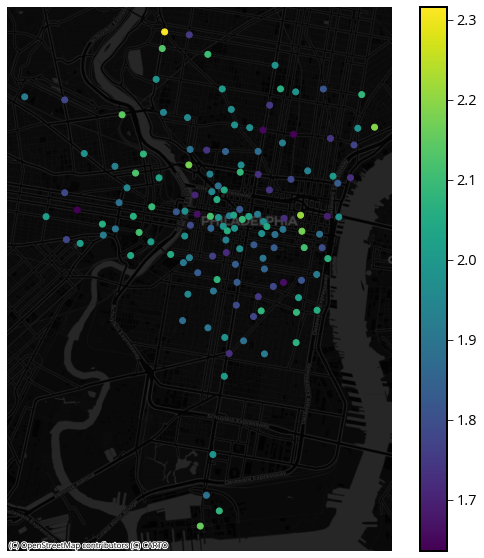

In [88]:
fig, ax = plt.subplots(figsize=(10,10))

# stations
bike_data.plot(ax=ax, column='logIntersectionDists', legend=True)

# plot the basemap underneath
ctx.add_basemap(ax=ax, crs=bike_data.crs, source=ctx.providers.CartoDB.DarkMatter)

ax.set_axis_off()

## 5. Neighboring Stations

- We need to include features that encodes the fact that demand for a specific station is likely related to the demand in neighboring stations
- This idea is known as **spatial lag**

We will add two new features:

1. The average distance to the nearest 5 stations
1. The average trip total for the nearest 5 stations

First, find the nearest 5 stations:

In [89]:
N = 5
k = N + 1
nbrs = NearestNeighbors(n_neighbors=k)
nbrs.fit(stationsXY)

stationDists, stationIndices = nbrs.kneighbors(stationsXY)

#### Notes

- We are matching the stations to themselves to find the nearest neighbors
- The closest match will always be the same station (distance of 0)
- So we fit for $k+1$ neighbors and will remove the closest neighbor

The log of the distances to the 5 nearest stations:

In [90]:
bike_data["logStationDists"] = np.log10(stationDists[:, 1:].mean(axis=1))

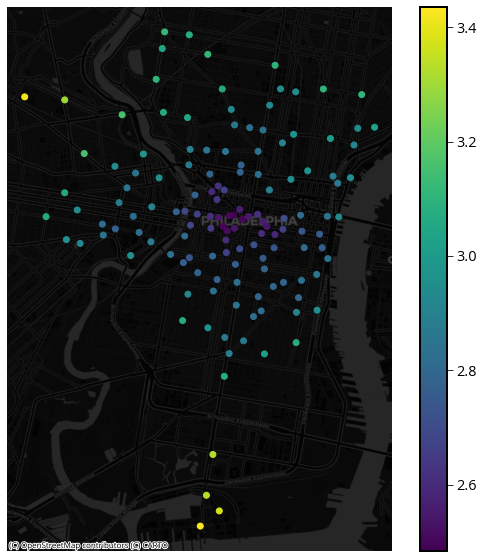

In [91]:
fig, ax = plt.subplots(figsize=(10,10))

# stations
bike_data.plot(ax=ax, column='logStationDists', legend=True)

# plot the basemap underneath
ctx.add_basemap(ax=ax, crs=bike_data.crs, source=ctx.providers.CartoDB.DarkMatter)

ax.set_axis_off()

Now, let's add the trip counts of the 5 neighboring stations:

**Use the indices returned by the NearestNeighbors() algorithm to identify which stations are the 5 neighbors in the original data**

In [92]:
stationIndices[:, 1:]

array([[  2,  47, 129,   4,  23],
       [  4,  88,   5, 129,   3],
       [  0,   4, 129,   3,   1],
       [127,   5,   2,   4,   1],
       [  1, 129,   2,   3,   0],
       [127,  88,   3,   1, 123],
       [ 57,  56,  20,  28,   7],
       [ 38,  57,   6,  80,  20],
       [113,   9, 118,  86,  35],
       [113,   8,  39,  32, 118],
       [ 96,  61,  55, 122,  13],
       [ 41,  22,  66, 137,  75],
       [ 39,  33,  32,  83,  15],
       [ 73,  55,  14, 131,   3],
       [ 73,  13,  89, 135,  76],
       [118,  46,  77,  39,  12],
       [ 42,  44, 135,  76, 104],
       [ 85,  82,  81,  21,  75],
       [ 65, 128,  52,  19,  63],
       [ 18,  34,  70, 128,  65],
       [ 28,   6,  56,  57,  25],
       [ 75,  49,  87,  50,  85],
       [ 11,  93,  41,  90, 121],
       [ 26,  47, 122,   0,  24],
       [ 25,  26,  61, 122,  23],
       [ 24,  48,  26,  28,  61],
       [ 23, 122,  24,  47,  25],
       [ 28,  48,  25,  29,  56],
       [ 27,  20,  56,  25,  48],
       [ 59,  

In [93]:
# the total trips for the stations from original data frame
total_start_trips = bike_data['total_start_trips'].values

In [94]:
# get the trips for the 5 nearest neighbors (ignoring first match)
neighboring_trips = total_start_trips[stationIndices[:, 1:]]

In [95]:
neighboring_trips

array([[22954, 11139,  1418,   128, 16455],
       [  128, 17070,  2248,  1418,  2683],
       [13712,   128,  1418,  2683, 27615],
       [10996,  2248, 22954,   128, 27615],
       [27615,  1418, 22954,  2683, 13712],
       [10996, 17070,  2683, 27615, 19088],
       [ 8585, 16600, 10807, 16130, 13719],
       [19439,  8585,  8253, 10183, 10807],
       [ 3041,  8671,  7132,  7069,  7160],
       [ 3041,  8843, 16449,  1445,  7132],
       [21939, 22248, 26655, 16519, 32531],
       [ 9262,  2561, 12182,  1179,  2882],
       [16449, 20303,  1445,  6515,  6307],
       [14434, 26655, 15446, 16259,  2683],
       [14434, 32531, 13027,   492, 18357],
       [ 7132,  6621,  2869, 16449, 16831],
       [23842, 10586,   492, 18357, 12916],
       [10150,  5327,  5013,  2179,  2882],
       [10366,  5301,  9803,  8972, 27760],
       [ 3574, 14102, 16345,  5301, 10366],
       [16130,  8253, 16600,  8585, 11548],
       [ 2882,  8449,  9918,  4582, 10150],
       [ 4887,  4420,  9262,  68

In [96]:
# Add to features
bike_data['laggedTrips'] = neighboring_trips.mean(axis=1)

### Is there a correlation between trip counts and the spatial lag?

Yes!

We can use seaborn to make a quick plot:

/Users/nhand/opt/miniconda3/envs/musa-550-fall-2021/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


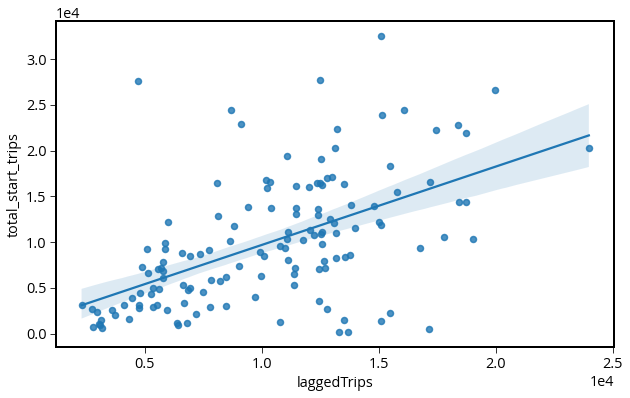

In [97]:
sns.regplot(bike_data['laggedTrips'], bike_data['total_start_trips']);

## Let's look at the correlations of all of our features

Again, use seaborn to investigate.

**Remember:** we don't want to include multipl features that are highly correlated in our model.

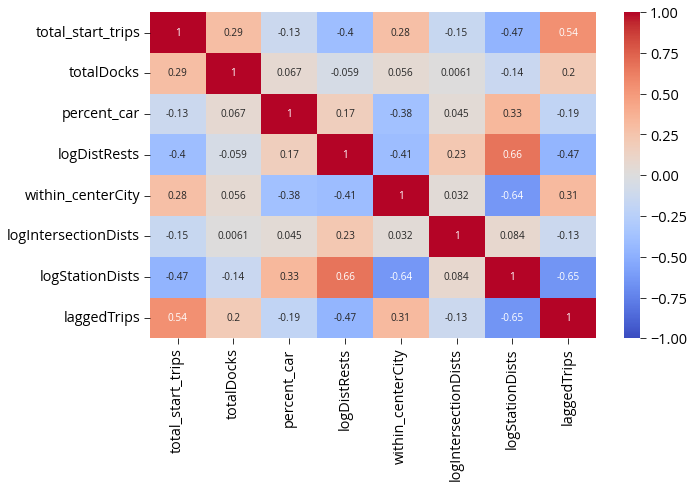

In [99]:
feature_cols = [
    "total_start_trips",
    "totalDocks",
    "percent_car",
    "logDistRests",
    "within_centerCity",
    "logIntersectionDists",
    "logStationDists",
    "laggedTrips",
]


sns.heatmap(
    bike_data[feature_cols].corr(), cmap="coolwarm", annot=True, vmin=-1, vmax=1
);

## Let's fit a model!

Just as before, the plan is to:
- Fit a random forest model, using cross validation to optimize (some) hyperparameters
- Compare to a baseline linear regression model

## Perform our test/train split

We'll use a 60%/40% split, due to the relatively small number of stations.

In [100]:
# Remove unnecessary columns
bike_features = bike_data.drop(labels=["geometry", "kioskId", "start_station"], axis=1)

In [101]:
# Split the data 
train_set, test_set = train_test_split(
    bike_features,
    test_size=0.4,
    random_state=12345,
)

# the target labels: log of total start trips
y_train = np.log(train_set["total_start_trips"])
y_test = np.log(test_set["total_start_trips"])

In [102]:
# Extract out only the features we want to use
feature_cols = [
    "totalDocks",
    "percent_car",
    "logDistRests",
    "within_centerCity",
    "logIntersectionDists",
    "logStationDists",
    "laggedTrips",
]

train_set = train_set[feature_cols]
test_set = test_set[feature_cols]

## Random forest results

Let's run a simple grid search to try to optimize our hyperparameters.

In [103]:
# Setup the pipeline with a standard scaler
pipe = make_pipeline(
    StandardScaler(), RandomForestRegressor(random_state=42)
)

Try out a few different values for two of the main parameters for random forests: `n_estimators` and `max_depth`:

In [104]:
model_name = "randomforestregressor"
param_grid = {
    f"{model_name}__n_estimators": [5, 10, 15, 20, 30],
    f"{model_name}__max_depth": [None, 2, 5, 7, 9, 13],
}

param_grid

{'randomforestregressor__n_estimators': [5, 10, 15, 20, 30],
 'randomforestregressor__max_depth': [None, 2, 5, 7, 9, 13]}

**Important:** just like last week, we will need to prefix the parameter name with the name of the pipeline step, in this case, "randomforestregressor".

In [105]:
# Create the grid and use 5-fold CV
grid = GridSearchCV(pipe, param_grid, cv=5)

# Run the search
grid.fit(train_set, y_train);

### Evaluate the best estimator on the test set:

In [106]:
grid.best_params_

{'randomforestregressor__max_depth': 2,
 'randomforestregressor__n_estimators': 15}

In [107]:
# Evaluate the best random forest model
best_random = grid.best_estimator_
grid.score(test_set, y_test)

0.22639730821531423

### Evaluate a linear model (baseline) on the test set

In [108]:
# Set up a linear pipeline
linear = make_pipeline(StandardScaler(), LinearRegression())

# Fit on train set
linear.fit(train_set, y_train)

# Evaluate on test set
linear.score(test_set, y_test)

0.14724175774189796

## Which features were the most important?

From our earlier correlation analysis, we should expect the most important features to be:
- the spatially lagged trip counts
- the distance to the nearest stations

In [109]:
# The best model
regressor = grid.best_estimator_["randomforestregressor"]

# Create the dataframe with importances
importance = pd.DataFrame(
    {"Feature": train_set.columns, "Importance": regressor.feature_importances_}
)

# Sort importance in descending order and get the top
importance = importance.sort_values("Importance", ascending=False)

# Plot
importance.hvplot.barh(x="Feature", y="Importance", flip_yaxis=True, height=300)

:Bars   [Feature]   (Importance)

In [110]:
importance

Feature  Importance
6           laggedTrips    0.372430
5       logStationDists    0.326055
2          logDistRests    0.194931
0            totalDocks    0.052708
1           percent_car    0.027478
4  logIntersectionDists    0.026399
3     within_centerCity    0.000000

## Let's analyze the spatial structure of the predictions visually

We'll plot the predicted and actual trip values

Use the test set index (`test_set.index`) to get the data from the original data frame (`bike_data`).

This will ensure we will have `geometry` info (not used in the modeling) for our test data set:

In [111]:
test_set.index

Int64Index([ 48,  44,   8,  18,  88, 133,  23,  73,  34,  91,  84,  27,  32,
            100, 131, 103,   9,  85, 110,  90,   6,  93,  68,  70,  40,  50,
             49,  57, 104,  26,  28,  37,  39, 128, 116,  30, 109,  72,  45,
             11,  24,  63,  89, 124,  47, 113,  99,   2,  20,  75,  31,  80,
              1,  79,  78, 135],
           dtype='int64')

In [112]:
# Extract the test data from the original dataset
# This will include the geometry data
X = bike_data.loc[test_set.index]

In [113]:
# test data extracted from our original data frame
X.head()

geometry  kioskId  start_station  \
48  POINT (-8366907.625 4860485.663)     3059           3059   
44  POINT (-8366168.463 4858841.711)     3055           3055   
8   POINT (-8368717.680 4857543.589)     3012           3012   
18  POINT (-8369358.880 4859364.493)     3022           3022   
88  POINT (-8373896.262 4862805.375)     3117           3117   

    total_start_trips  totalDocks  percent_car  logDistRests  \
48              13813          21     0.373358      2.450591   
44              11548          15     0.195913      2.521296   
8               22399          27     0.326613      2.799866   
18              20303          21     0.233906      2.767425   
88               1524          19     0.868263      3.400058   

    within_centerCity  logIntersectionDists  logStationDists  laggedTrips  
48                  0              1.732323         2.829790       9414.6  
44                  1              1.903502         2.660166      14002.2  
8                   0              1.829686         2.782236      13238.6  
18                  0              1.821412         2.774140      13132.0  
88                  0              1.916505         3.419593       3140.2

In [114]:
test_set.head()

totalDocks  percent_car  logDistRests  within_centerCity  \
48          21     0.373358      2.450591                  0   
44          15     0.195913      2.521296                  1   
8           27     0.326613      2.799866                  0   
18          21     0.233906      2.767425                  0   
88          19     0.868263      3.400058                  0   

    logIntersectionDists  logStationDists  laggedTrips  
48              1.732323         2.829790       9414.6  
44              1.903502         2.660166      14002.2  
8               1.829686         2.782236      13238.6  
18              1.821412         2.774140      13132.0  
88              1.916505         3.419593       3140.2

 #### The data frame indices lines up!

Now, make our predictions, and convert them from log to raw counts:

In [115]:
# Predictions for log of total trip counts
log_predictions = grid.best_estimator_.predict(test_set)

# Convert the predicted test values from log
X['prediction'] = np.exp(log_predictions)

Let's make the plot with side-by-side panels for actual and predicted:

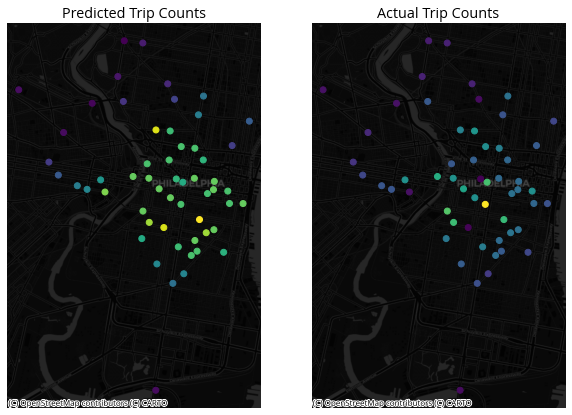

In [116]:
# Plot two columns
fig, axs = plt.subplots(ncols=2, figsize=(10,10))

# Predicted values
X.plot(ax=axs[0], column='prediction')
ctx.add_basemap(ax=axs[0], crs=X.crs, source=ctx.providers.CartoDB.DarkMatter)
axs[0].set_title("Predicted Trip Counts")

# Actual values
X.plot(ax=axs[1], column='total_start_trips')
ctx.add_basemap(ax=axs[1], crs=X.crs, source=ctx.providers.CartoDB.DarkMatter)
axs[1].set_title("Actual Trip Counts")


axs[0].set_axis_off()
axs[1].set_axis_off()

## The results are... not great

#### The good
We are capturing the general trend of within Center City vs. outside Center City

#### The bad
The values of the trip counts for those stations within Center City do not seem to be well-represented

## Can we improve the model?

Yes! 

This is a classic example of underfitting, for a few reasons:

- The analysis only used seven features. We should be able to improve the fit by adding more features, particularly features that capture information of the stations within Center City (where the model seems to be struggling).
- The correlation analysis did not indicate much correlation between features, and the features all had a pretty large correlation with the total trip counts. So, in some sense, the features all seem to be important, and we just need to add more.

## Features to investigate:

- Additional census demographic data: 
    - e.g., population, income, percent with bachelor's degree or higher
    - See https://api.census.gov/data/2019/acs/acs5/variables.html for column names!
- Amenities / disamenities
    - Lots of options from OpenDataPhilly and OpenStreetMap
    - Criminal incidents, distance to parks, restaurants, new construction permits, etc.
- Transportation network
    - Distance to the nearest bus station is a good place to start (see https://wiki.openstreetmap.org/wiki/Map_Features for the amenity tag)
- Changing $k$ values for distance-based features
    - Experiment with different values of $k$ to see if they improve the model

## Other options for bikeshare data

When trying to improve the accuracy of the model, another option is incorporating additional data. In this case, we can look to other cities and include trip data for these cities. Some good places to start:

- [Boston](https://www.bluebikes.com/system-data)
- [Chicago](https://www.divvybikes.com/system-data)
- [Washington D.C](https://www.capitalbikeshare.com/system-data)


## That's it!

- Office hours tomorrow evening
- On Wednesday we start our introduction to web browsers and dashboarding!
